In [2]:
from owlready2 import *
import re
import fasttext 
import numpy as np
from numpy import dot
from numpy.linalg import norm
import networkx as nx
import hnswlib
from os import path

In [13]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')
def embed(inputTexts):
    return model.encode(inputTexts)

In [14]:
def cosineSimilarity(a, b):
    return np.inner(a, b)/(norm(a)*norm(b))


# Usage: split(name.lower) for name in class_names_list
def delimSplit(string, delimiters = ['-','_'], maxsplit=0):
    import re
    regexPattern = '|'.join(map(re.escape, delimiters))
    return [word for word in re.split(regexPattern, string, maxsplit) if len(word) > 0]

def getName(string):
    nameList= delimSplit(string)
    return ' '.join(nameList)

def preprocessString(string):
    string = string.lower()
    string = re.sub("[^a-zA-Z]", " ", string)            # remove non alphabets with a space which is used as a delimiter later
    return string

In [15]:
def buildIndexer(docEmbeddings):
    numElements = len(docEmbeddings)
    dimension = len(docEmbeddings[0])
    embeddings = np.asarray(docEmbeddings)
    data_labels = np.arange(numElements)
    p = hnswlib.Index(space = 'cosine', dim = dimension) # possible options are l2, cosine or ip
    p.init_index(max_elements = numElements, ef_construction = 200, M = dimension)
    p.add_items(embeddings, data_labels)
    p.set_ef(30) 
    return p

def saveIndexer(p):
    index_path='./models/topicsHnwslib.bin'
    print("Saving index to '%s'" % index_path)
    p.save_index("./models/topicsHnwslib.bin")

def loadIndexer(filepath, numElements):
    p = hnswlib.Index(space='cosine', dim=dimension)  # the space can be changed - keeps the data, alters the distance function.
    p.load_index("./models/topicsHnwslib.bin", max_elements = numElements)
    return p


In [16]:
def getQueryEmbedding(query, entity = False):
    if entity:
        raise NotImplementedError
    else:
        return embed([query])[0]
    
def getSeedTopics(query, topicNames, indexer, numSeeds = 2):
    queryEmbedding = getQueryEmbedding(query, entity = False)
    if indexer is None:
        if path.exists("./models/topicsHnwslib.bin"):
            indexer = loadIndexer(filepath = "./models/topicsHnwslib.bin", len(topicNames))
        else:
            topicEmbeddings = embed(topicNames)
            indexer = buildIndexer(topicEmbeddings)
            saveIndexer(indexer)
    labels, _ = indexer.knn_query(queryEmbedding, k = numSeeds )

        
    return [topicNames[ind] for ind in labels]

In [ ]:
def chunkedEmbeddings(enityList):   
    n = 100     # block size
    entities = [entityList[i:i + n] for i in range(0, len(entityList), n)]
    embeddingList = []
    count = 0
    for entitySubList in tqdm(entities):
        embeddings = embed(entitySubList)#.numpy().tolist()
        for embedding in embeddings:
            embeddingList.append(embedding)
            count += 1
    return embeddingList                  
    assert count == len(entityList)

In [8]:
file_prefix = 'file://'
onto = get_ontology(file_prefix + "./data/ontology.owl").load()

In [9]:
class_list = list(onto.classes())

phraseToClassDict = {}                             ## 'absolute error loss' mapped to ontology.Absolute_Error_Loss
for c in class_list:
    phraseToClassDict[getName(c.name.lower())] = c

In [10]:
adjList = dict()
for c in class_list:
    adjList[getName(c.name.lower())] = [getName(s.name.lower()) for s in c.subclasses()]
G = nx.from_dict_of_lists(adjList)                     ## vertex names are of the form: absolute error loss
print('Number of nodes: ', len(list(G.nodes)), '. Number of edges: ', len(list(G.edges())))

Number of nodes:  1074 . Number of edges:  1090


In [17]:
topicNames = list(phraseToClassDict.keys())
topicEmbeddings = embed(topicNames)

In [ ]:
getSeedTopics('logisitic regression', topicNames, None, numSeeds = 2)

In [20]:
from gensim.models.poincare import PoincareModel
relations = list(G.edges())
model = PoincareModel(relations, negative=2)
model.train(epochs=50)

In [23]:
from gensim.viz.poincare import poincare_2d_visualization
poincare_2d_visualization(model, set(relations), 'title', num_nodes=50, show_node_labels=())

ValueError: Can only plot 2-D vectors

ValueError: Can only plot 2-D vectors

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
def tsne_plot(model):  
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.kv.vocab:
        tokens.append(model.kv.get_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

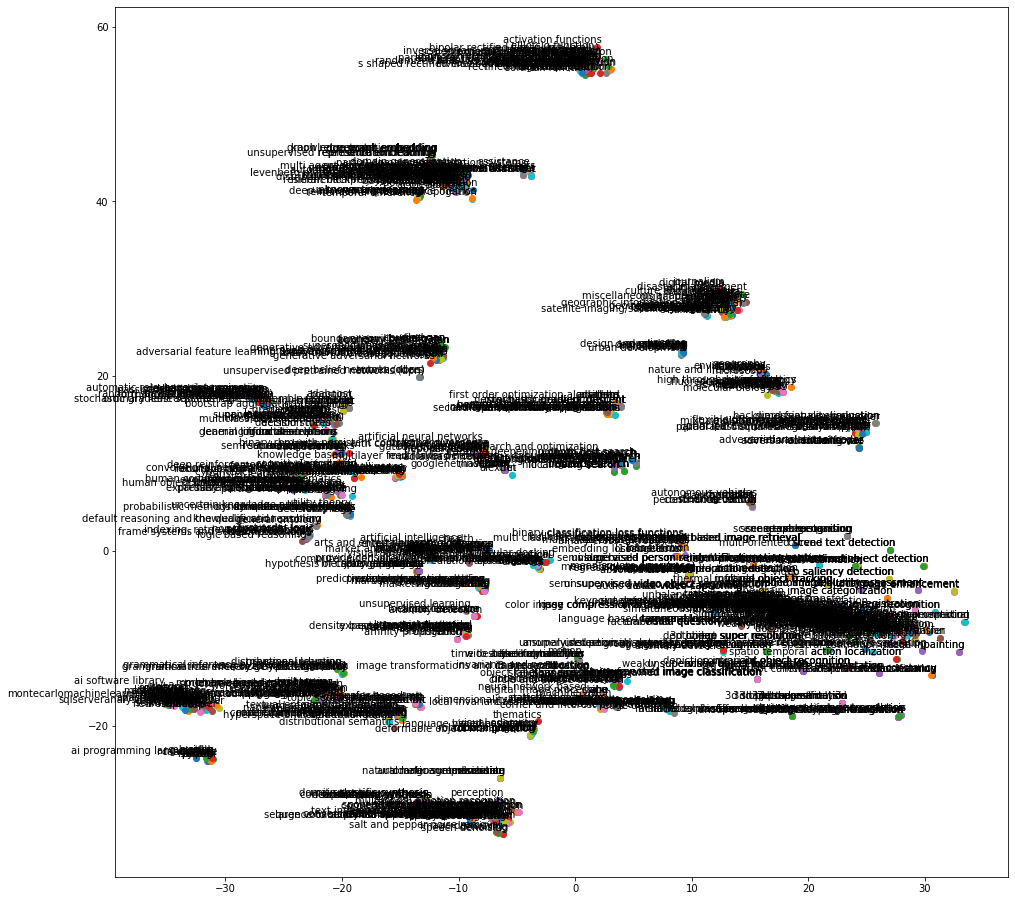

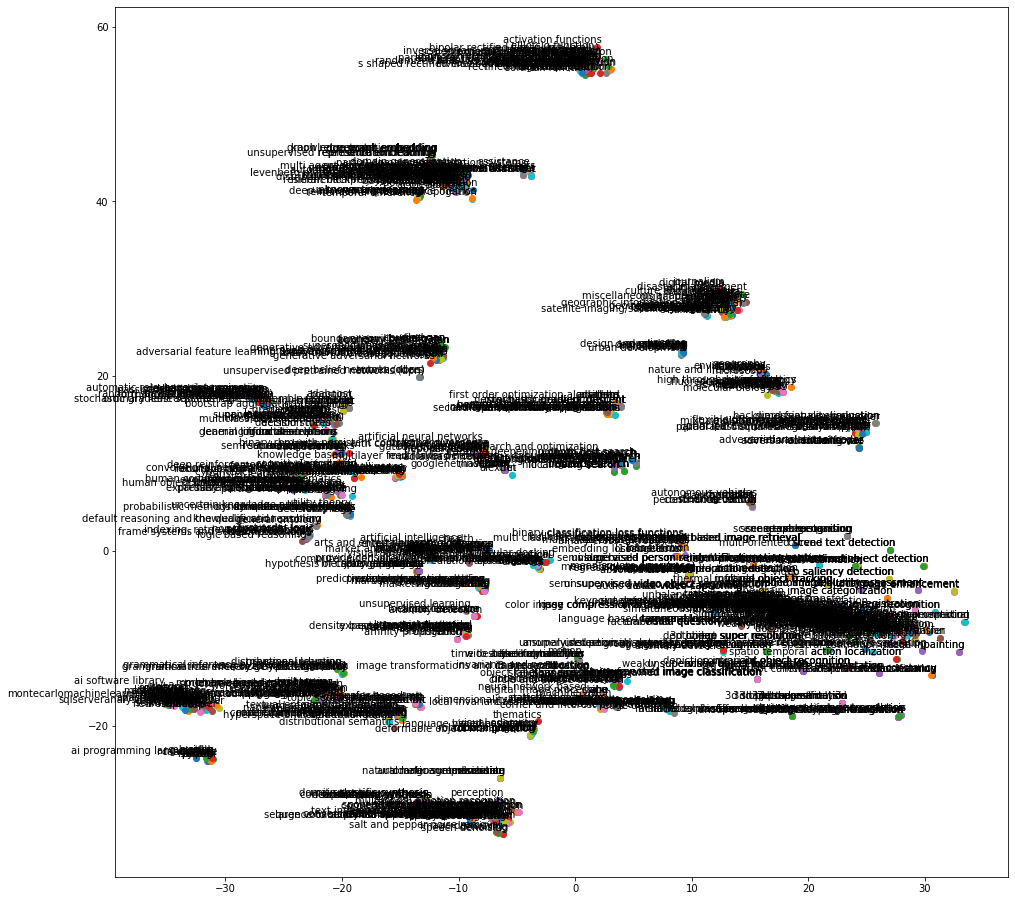

In [33]:
tsne_plot(model)

In [38]:
model.kv.most_similar('chatbots')

[('conversational bot', 0.14262441351319782),
 ('personal assistant', 0.22780726713794536),
 ('verbal assistant', 0.2642991692430936),
 ('bots', 0.399117495650599),
 ('collaborative filtering', 0.6891708398831656),
 ('session based recommendations', 0.7130494416753574),
 ('content based filtering', 0.7230437834678549),
 ('video object segmentation', 1.3233252389603947),
 ('sociology', 1.3470926795690297),
 ('unsupervised video object segmentation', 1.3474609584183526)]

[('conversational bot', 0.14262441351319782),
 ('personal assistant', 0.22780726713794536),
 ('verbal assistant', 0.2642991692430936),
 ('bots', 0.399117495650599),
 ('collaborative filtering', 0.6891708398831656),
 ('session based recommendations', 0.7130494416753574),
 ('content based filtering', 0.7230437834678549),
 ('video object segmentation', 1.3233252389603947),
 ('sociology', 1.3470926795690297),
 ('unsupervised video object segmentation', 1.3474609584183526)]

In [34]:
adjList

{'absolute error loss': ['mean absolute error (mae)'],
 'activation functions': ['arsinh function',
  'arctan function',
  'bent identity function',
  'binary step function',
  'bipolar step function',
  'elliotsig function',
  'gaussian function',
  'identity function',
  'logistic function',
  'maxout function',
  'ramp function',
  'sq rbf function',
  'sqnl function',
  'sinc function',
  'sinusoid function',
  'softexponential function',
  'softplus function',
  'soft clipping function',
  'softmax function',
  'tanh function',
  'adaptive piecewise linear (apl)',
  'bipolar rectified linear unit (brelu)',
  'exponential linear unit (elu)',
  'gaussian error linear units (gelu)',
  'inverse square root linear unit (isrlu)',
  'inverse square root unit (isru)',
  'leaky rectified linear unit (leaky relu)',
  'parameteric rectified linear unit (prelu)',
  'randomized leaky rectified linear unit (rrelu)',
  'rectified linear unit (relu)',
  's shaped rectified linear activation unit 

{'absolute error loss': ['mean absolute error (mae)'],
 'activation functions': ['arsinh function',
  'arctan function',
  'bent identity function',
  'binary step function',
  'bipolar step function',
  'elliotsig function',
  'gaussian function',
  'identity function',
  'logistic function',
  'maxout function',
  'ramp function',
  'sq rbf function',
  'sqnl function',
  'sinc function',
  'sinusoid function',
  'softexponential function',
  'softplus function',
  'soft clipping function',
  'softmax function',
  'tanh function',
  'adaptive piecewise linear (apl)',
  'bipolar rectified linear unit (brelu)',
  'exponential linear unit (elu)',
  'gaussian error linear units (gelu)',
  'inverse square root linear unit (isrlu)',
  'inverse square root unit (isru)',
  'leaky rectified linear unit (leaky relu)',
  'parameteric rectified linear unit (prelu)',
  'randomized leaky rectified linear unit (rrelu)',
  'rectified linear unit (relu)',
  's shaped rectified linear activation unit 

In [37]:
model.kv.most_similar((model.kv.get_vector('breadth first search') + model.kv.get_vector('depth first search')) / 2)

[('brute force search', 0.19183763624449512),
 ('depth first search', 0.2423863112190886),
 ('uniform cost search', 0.24792623709578712),
 ('breadth first search', 0.28157797099336207),
 ('bidirectional search', 0.3022612707588843),
 ('iterative deepening depth first search', 0.37466425974563805),
 ('blind search', 0.7110479923891726),
 ('tabu search algorithm', 0.734821229458574),
 ('search algorithms', 0.7509061587479332),
 ('gravitational search algorithm', 0.7789498463447094)]

[('brute force search', 0.19183763624449512),
 ('depth first search', 0.2423863112190886),
 ('uniform cost search', 0.24792623709578712),
 ('breadth first search', 0.28157797099336207),
 ('bidirectional search', 0.3022612707588843),
 ('iterative deepening depth first search', 0.37466425974563805),
 ('blind search', 0.7110479923891726),
 ('tabu search algorithm', 0.734821229458574),
 ('search algorithms', 0.7509061587479332),
 ('gravitational search algorithm', 0.7789498463447094)]

In [39]:
model.kv.most_similar((model.kv.get_vector('adam') + model.kv.get_vector('adagrad')) / 2)

[('adam', 0.014114604754161875),
 ('adagrad', 0.014183437772351783),
 ('adadelta', 0.029745172911442),
 ('first order optimization algorithms', 0.039091551339758855),
 ('mini batch gradient descent', 0.663839885552896),
 ('nesterov accelerated gradient', 0.6787875250172928),
 ('gradient descent', 0.6886457532065207),
 ('stochastic gradient descent', 0.7253832900773263),
 ('second order optimization algorithms', 1.0734767399911862),
 ('optimization algorithms', 1.084217470829965)]

[('adam', 0.014114604754161875),
 ('adagrad', 0.014183437772351783),
 ('adadelta', 0.029745172911442),
 ('first order optimization algorithms', 0.039091551339758855),
 ('mini batch gradient descent', 0.663839885552896),
 ('nesterov accelerated gradient', 0.6787875250172928),
 ('gradient descent', 0.6886457532065207),
 ('stochastic gradient descent', 0.7253832900773263),
 ('second order optimization algorithms', 1.0734767399911862),
 ('optimization algorithms', 1.084217470829965)]

In [40]:
model.kv.most_similar('sigmoid function')

[('binary sigmoidal function', 0.18241587641269197),
 ('bipolar sigmoidal function', 0.1863036112783289),
 ('sigmoidal function', 0.30586660940945043),
 ('softstep function', 0.3181918899998072),
 ('logistic function', 0.3612456003548927),
 ('maxout function', 0.5592107072006494),
 ('ramp function', 0.5592362361320333),
 ('bipolar step function', 0.5596667536528842),
 ('leaky rectified linear unit (leaky relu)', 0.5611363902813842),
 ('sigmoid linear unit (silu)', 0.5618453955212401)]

[('binary sigmoidal function', 0.18241587641269197),
 ('bipolar sigmoidal function', 0.1863036112783289),
 ('sigmoidal function', 0.30586660940945043),
 ('softstep function', 0.3181918899998072),
 ('logistic function', 0.3612456003548927),
 ('maxout function', 0.5592107072006494),
 ('ramp function', 0.5592362361320333),
 ('bipolar step function', 0.5596667536528842),
 ('leaky rectified linear unit (leaky relu)', 0.5611363902813842),
 ('sigmoid linear unit (silu)', 0.5618453955212401)]